In [2]:
!python3.6 -m pip install tensorboardX
!python3.6 -m pip install torch
!python3.6 -m pip install librosa
!apt-get install libsndfile1 --yes

     |████████████████████████████████| 204kB 902kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 734.6MB 125kB/s  eta 0:00:01███████████████▎          | 488.8MB 12.1MB/s eta 0:00:21     |████████████████████████████▌   | 653.5MB 10.6MB/s eta 0:00:08
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 1.6MB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 26.1MB 10.6MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 8.0MB/s eta 0:00:01
     |████████████████████████████████| 296kB 7.6MB/s eta 0:00:01
     |████████████████████████████████| 327kB 14.0MB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 7.2MB/s eta 0:00:01
     |████████████████████████████████| 20.2MB 10.5MB/s eta 0:00:01
     |████████████████████████████████| 399kB 5.4MB/s eta 0:00:01
     |████████████████████████████████| 163kB 13.7MB/s eta

(Reading database ... 15402 files and directories currently installed.)
Preparing to unpack .../libogg0_1.3.2-1_amd64.deb ...
Unpacking libogg0:amd64 (1.3.2-1) ...
Selecting previously unselected package libflac8:amd64.
Preparing to unpack .../libflac8_1.3.2-1_amd64.deb ...
Unpacking libflac8:amd64 (1.3.2-1) ...
Selecting previously unselected package libvorbis0a:amd64.
Preparing to unpack .../libvorbis0a_1.3.5-4.2_amd64.deb ...
Unpacking libvorbis0a:amd64 (1.3.5-4.2) ...
Selecting previously unselected package libvorbisenc2:amd64.
Preparing to unpack .../libvorbisenc2_1.3.5-4.2_amd64.deb ...
Unpacking libvorbisenc2:amd64 (1.3.5-4.2) ...
Selecting previously unselected package libsndfile1:amd64.
Preparing to unpack .../libsndfile1_1.0.28-4ubuntu0.18.04.1_amd64.deb ...
Unpacking libsndfile1:amd64 (1.0.28-4ubuntu0.18.04.1) ...
Setting up libogg0:amd64 (1.3.2-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up libvorbis0a:amd64 (1.3.5-4.2) ...
Setting up libflac8:amd64 

# Test code copy

load model from model_vctk/model_vctk-0
(325, 513)


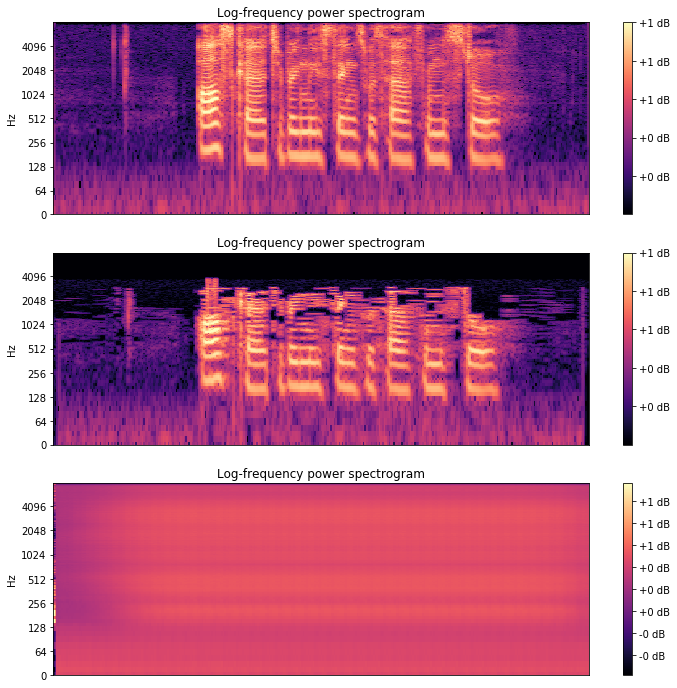

In [46]:
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import pickle
from utils import Hps
from preprocess.tacotron.norm_utils import spectrogram2wav, get_spectrograms
from scipy.io.wavfile import write
import glob
import os
from solver import Solver
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

args_hps='vctk.json'
args_model="model_vctk/model_vctk-0"
args_source="test/p225_002.wav"
args_source_8="test/p225_002-8.wav"
args_target=18
args_output="test/output.wav"
args_sample_rate=16000
args_use_gen=False

hps = Hps()
hps.load(args_hps)
hps_tuple = hps.get_tuple()
solver = Solver(hps_tuple, None)
solver.load_model(args_model)
_, spec = get_spectrograms(args_source)
_, spec_8 = get_spectrograms(args_source_8)

spec_expand = np.expand_dims(spec, axis=0)
spec_tensor = torch.from_numpy(spec_expand).type(torch.FloatTensor)
c = Variable(torch.from_numpy(np.array([int(args_target)]))).cuda()
result = solver.test_step(spec_tensor, c, gen=args_use_gen)
result = result.squeeze(axis=0).transpose((1, 0))
wav_data = spectrogram2wav(result)
write(args_output, rate=args_sample_rate, data=wav_data)

print(spec.shape)
plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
librosa.display.specshow(spec.T, y_axis='log', sr=16000)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

plt.subplot(3,1,2)
librosa.display.specshow(spec_8.T, y_axis='log', sr=16000)
plt.colorbar(format='%+2.00f dB')
plt.title('Log-frequency power spectrogram')


plt.subplot(3,1,3)
librosa.display.specshow(result.T, y_axis='log', sr=16000)
plt.colorbar(format='%+2.00f dB')
plt.title('Log-frequency power spectrogram')


plt.show()

# Train code copy

In [48]:
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import pickle
from utils import Hps
from utils import DataLoader
from utils import Logger
from utils import SingleDataset
from solver import Solver
import argparse

args_load_model=False
args_flag='train'
args_hps_path="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk.json"
args_dataset_path_trg="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk_old/data.h5"
args_dataset_path="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk_old/data-8.h5"
args_index_path_trg="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk_old/index.json"
args_index_path="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/vctk_old/index-8.json"
args_output_model_path="/tf/notebooks/SKAJPAI/voice_style_transfer/voice_conversion/model_vctk/model_vctk"

hps = Hps()
hps.load(args_hps_path)
hps_tuple = hps.get_tuple()
dataset = SingleDataset(args_dataset_path, args_index_path, seg_len=hps_tuple.seg_len)
dataset_trg = SingleDataset(args_dataset_path_trg, args_index_path_trg, seg_len=hps_tuple.seg_len)
data_loader = DataLoader(dataset, dataset_trg)

solver = Solver(hps_tuple, data_loader)
if args_load_model:
    solver.load_model(args_load_model_path)

solver.train(args_output_model_path, args_flag, mode='pretrain_G')
solver.train(args_output_model_path, args_flag, mode='pretrain_D')
solver.train(args_output_model_path, args_flag, mode='train')
solver.train(args_output_model_path, args_flag, mode='patchGAN')

pre_G:[000001/008000], loss_rec=0.488
pre_G:[000002/008000], loss_rec=0.469
pre_G:[000003/008000], loss_rec=0.426
pre_G:[000004/008000], loss_rec=0.438
pre_G:[000005/008000], loss_rec=0.408
pre_G:[000006/008000], loss_rec=0.401
pre_G:[000007/008000], loss_rec=0.379
pre_G:[000008/008000], loss_rec=0.382
pre_G:[000009/008000], loss_rec=0.356
pre_G:[000010/008000], loss_rec=0.349
pre_G:[000011/008000], loss_rec=0.336
pre_G:[000012/008000], loss_rec=0.332
pre_G:[000013/008000], loss_rec=0.319
pre_G:[000014/008000], loss_rec=0.308
pre_G:[000015/008000], loss_rec=0.304
pre_G:[000016/008000], loss_rec=0.291
pre_G:[000017/008000], loss_rec=0.281
pre_G:[000018/008000], loss_rec=0.281
pre_G:[000019/008000], loss_rec=0.280
pre_G:[000020/008000], loss_rec=0.265
pre_G:[000021/008000], loss_rec=0.264
pre_G:[000022/008000], loss_rec=0.261
pre_G:[000023/008000], loss_rec=0.248
pre_G:[000024/008000], loss_rec=0.250
pre_G:[000025/008000], loss_rec=0.248
pre_G:[000026/008000], loss_rec=0.242
pre_G:[00002

KeyboardInterrupt: 